In [5]:
# Add ldcpy root to system path
import sys
import struct
from math import log2

import astropy
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '../../../')

# Import ldcpy package
# Autoreloads package everytime the package is called, so changes to code will be reflected in the notebook if the above sys.path.insert(...) line is uncommented.
%load_ext autoreload
%autoreload 2

# suppress all of the divide by zero warnings
import warnings

warnings.filterwarnings("ignore")

import ldcpy

# display the plots in this notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
os.environ["HDF5_PLUGIN_PATH"]

'/glade/work/haiyingx/H5Z-ZFP-PLUGIN-unbiased/plugin'

In [7]:
# col_ts is a collection containing TS data
col_ts = ldcpy.open_datasets(
    "cam-fv",
    ["TS"],
    [
        "../../../data/cam-fv/orig.TS.100days.nc",
        "../../../data/cam-fv/zfp1e-1.TS.100days.nc",
        "../../../data/cam-fv/zfp1.0.TS.100days.nc",
    ],
    ["orig", "zfpA1e-1", "zfpA1.0"],
)
# col_prect contains PRECT data
col_prect = ldcpy.open_datasets(
    "cam-fv",
    ["PRECT"],
    [
        "../../../data/cam-fv/orig.PRECT.60days.nc",
        "../../../data/cam-fv/zfp1e-11.PRECT.60days.nc",
        "../../../data/cam-fv/zfp1e-7.PRECT.60days.nc",
    ],
    ["orig", "zfpA1e-11", "zfpA1e-7"],
)

ts_array = np.array(col_ts["TS"].isel(time=0).values)
prect_array = np.array(col_prect["PRECT"].isel(time=0).values)


# See here for a list of variables with more information:
# https://www.cesm.ucar.edu/projects/community-projects/LENS/data-sets.html

# daily_variables = ["bc_a1_SRF", "dst_a1_SRF", "dst_a3_SRF", "FLNS", "FLNSC",
#                    "FLUT", "FSNS", "FSNSC", "FSNTOA", "ICEFRAC", "LHFLX", "pom_a1_SRF", "PRECL", "PRECSC",
#                    "PRECSL", "PRECT", "PRECTMX", "PSL", "Q200", "Q500", "Q850", "QBOT", "SHFLX", "so4_a1_SRF",
#                    "so4_a2_SRF", "so4_a3_SRF", "soa_a1_SRF", "soa_a2_SRF", "T010", "T200", "T500", "T850",
#                    "TAUX", "TAUY", "TMQ", "TREFHT", "TREFHTMN", "TREFHTMX", "TS", "U010", "U200", "U500", "U850", "VBOT",
#                    "WSPDSRFAV", "Z050", "Z500"]

daily_variables = ["TS", "FLNS", "ICEFRAC", "PRECT", "PSL", "Q200",
                   "TAUX", "WSPDSRFAV", "Z500"]
data_path = "/glade/p/cisl/asap/CAM_lossy_test_data_31/research"

zfp_array = ["zfp_p_8", "zfp_p_10", "zfp_p_12", "zfp_p_14", "zfp_p_16",
             "zfp_p_18", "zfp_p_20", "zfp_p_22", "zfp_p_24", "original"]

cols_daily = {}
sets = {}
levels = {}
climate_var_arrays = {}
for variable in daily_variables:
    print(variable)
    levels[variable] = [f"zfp_p_8_{variable}",
                        f"zfp_p_10_{variable}",
                        f"zfp_p_12_{variable}", f"zfp_p_14_{variable}",
                        f"zfp_p_16_{variable}", f"zfp_p_18_{variable}", f"zfp_p_20_{variable}",
                        f"zfp_p_22_{variable}", f"zfp_p_24_{variable}"]
    sets[variable] = [f"{data_path}/daily_zfp_hdf5/zfp_p_8/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc",
                      f"{data_path}/daily_zfp_hdf5/zfp_p_10/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc",
                      f"{data_path}/daily_zfp_hdf5/zfp_p_12/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc",
                      f"{data_path}/daily_zfp_hdf5/zfp_p_14/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc",
                      f"{data_path}/daily_zfp_hdf5/zfp_p_16/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc",
                      f"{data_path}/daily_zfp_hdf5/zfp_p_18/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc",
                      f"{data_path}/daily_zfp_hdf5/zfp_p_20/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc",
                      f"{data_path}/daily_zfp_hdf5/zfp_p_22/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc",
                      f"{data_path}/daily_zfp_hdf5/zfp_p_24/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc",
                      f"{data_path}/daily_orig/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc",]
    cols_daily[variable] = ldcpy.open_datasets("cam-fv", [f"{variable}"], sets[variable], levels[variable] +[f"orig_{variable}"], chunks={"time":700})
    climate_var_arrays[variable] = np.array(cols_daily[variable][variable].isel(time=0).values)

# array indexing example
# climate_var_arrays["TS"]

dataset size in GB 0.07

dataset size in GB 0.04

TS
dataset size in GB 1.62

FLNS
dataset size in GB 1.62

ICEFRAC
dataset size in GB 1.62

PRECT
dataset size in GB 1.62

PSL
dataset size in GB 1.62

Q200
dataset size in GB 1.62

TAUX
dataset size in GB 1.62

WSPDSRFAV
dataset size in GB 1.62

Z500
dataset size in GB 1.62



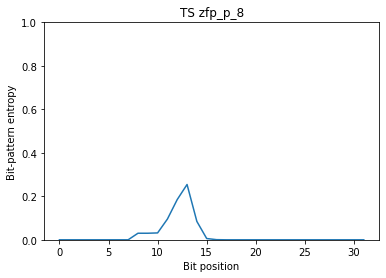

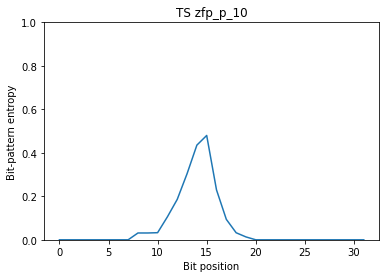

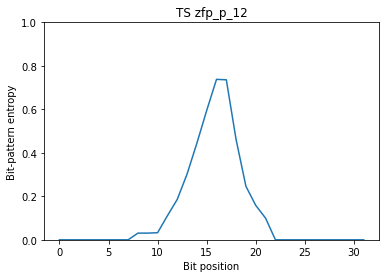

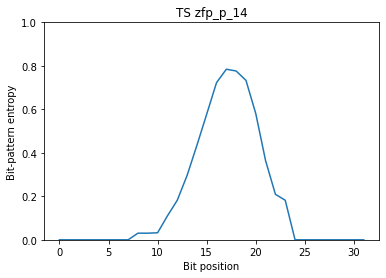

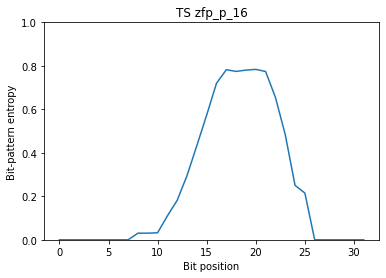

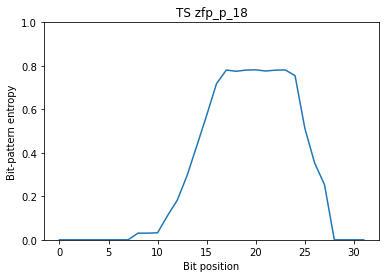

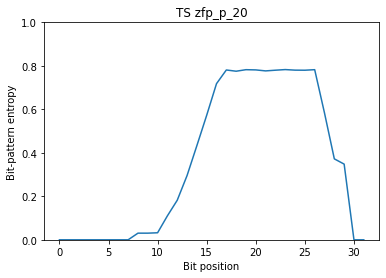

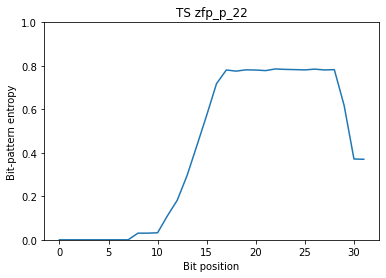

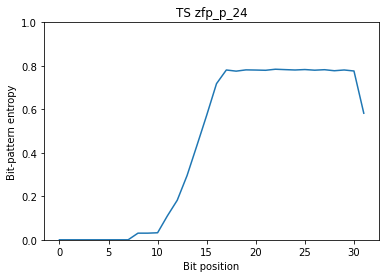

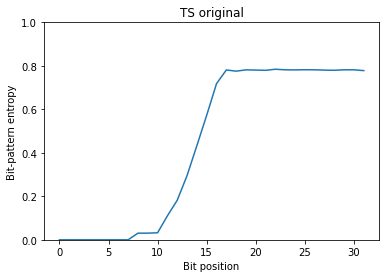

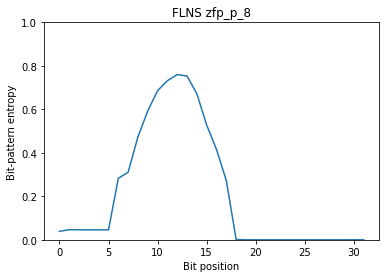

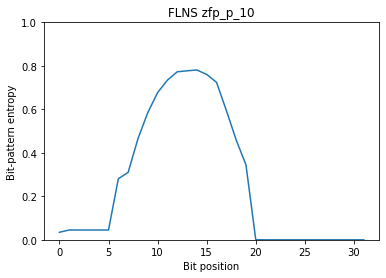

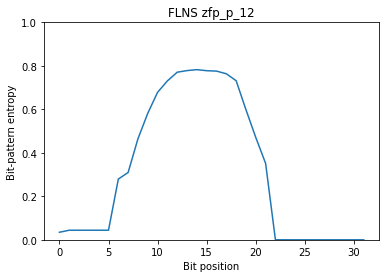

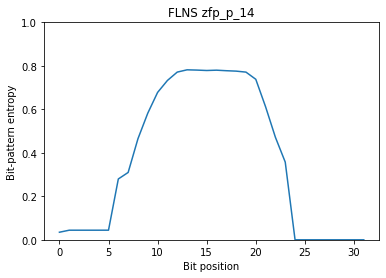

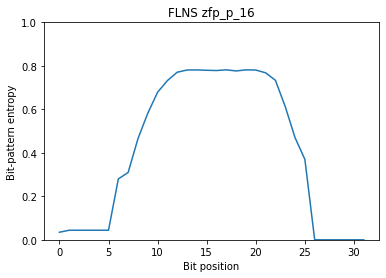

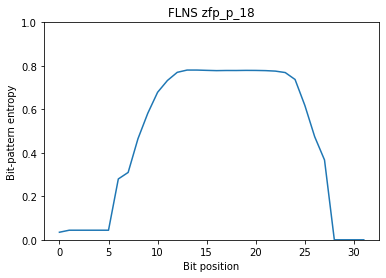

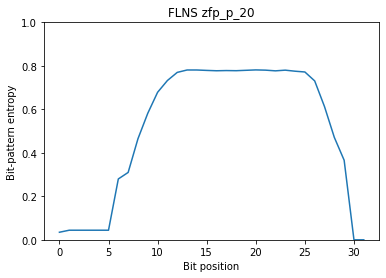

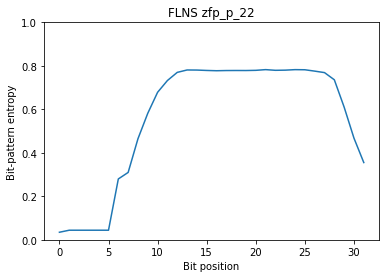

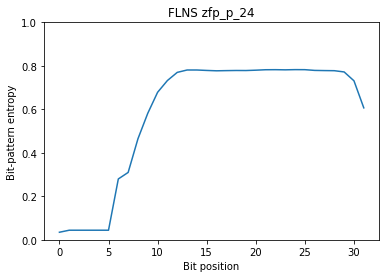

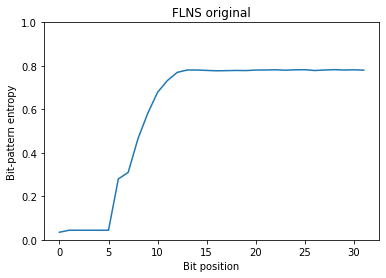

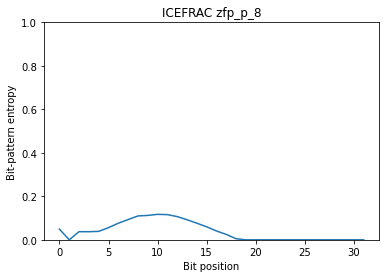

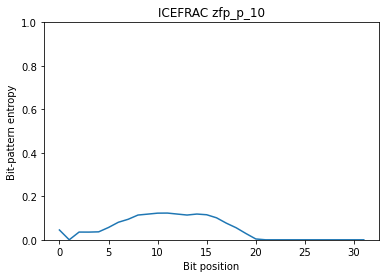

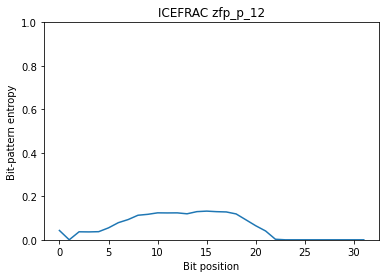

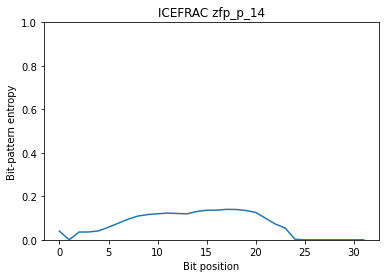

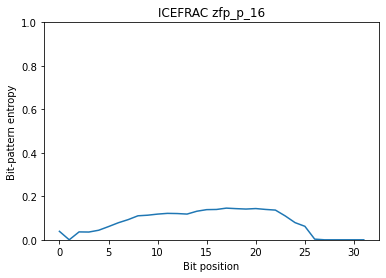

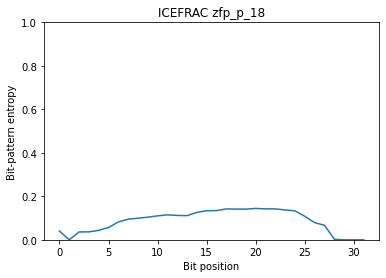

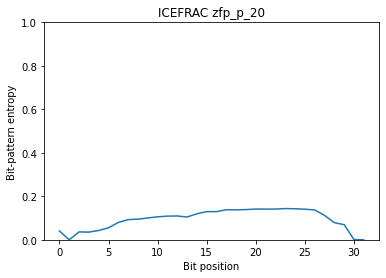

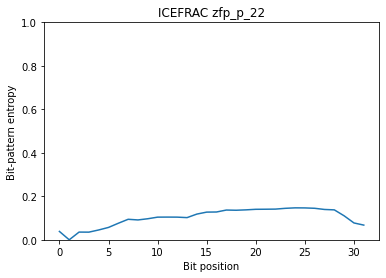

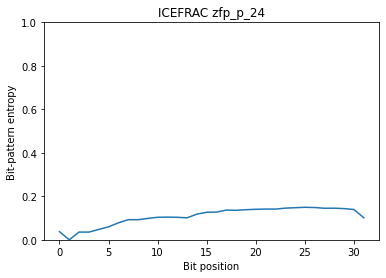

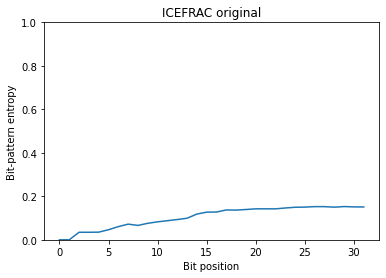

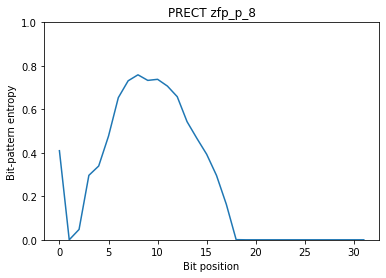

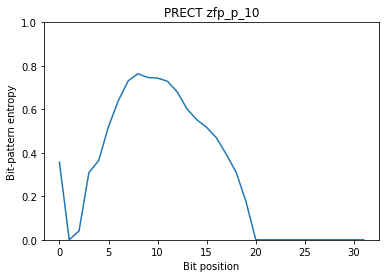

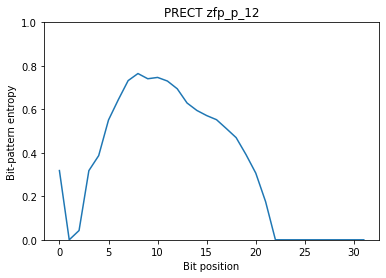

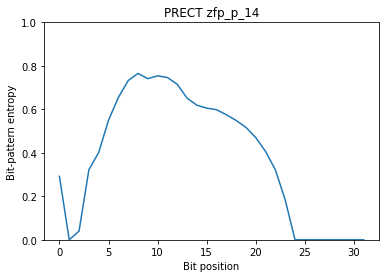

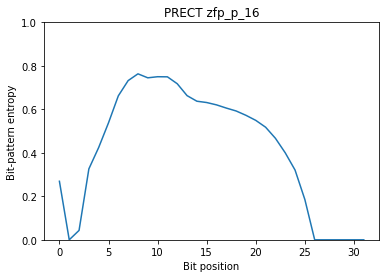

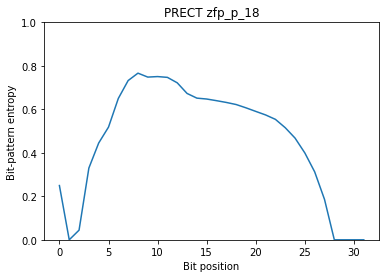

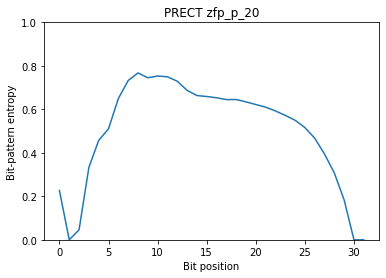

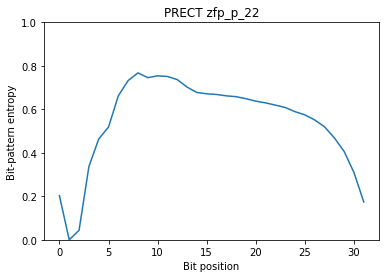

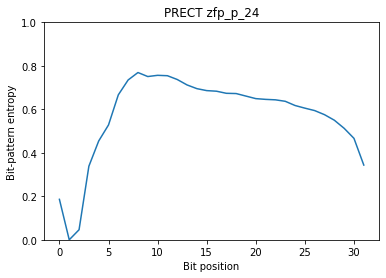

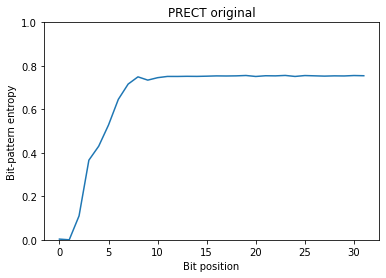

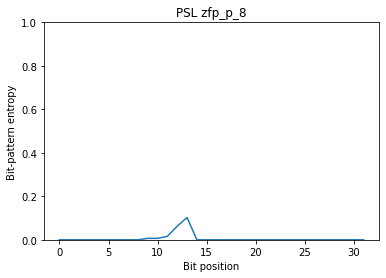

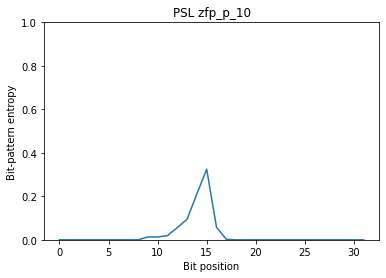

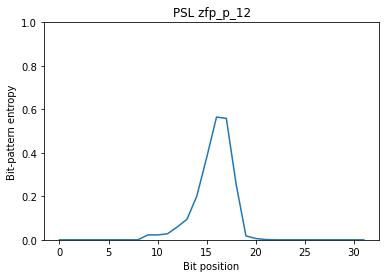

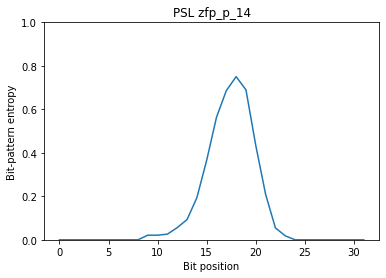

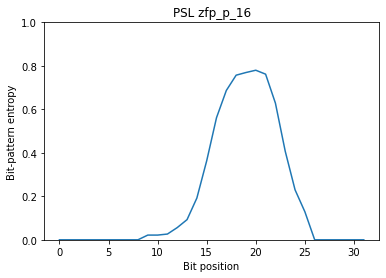

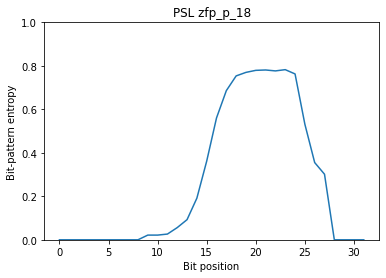

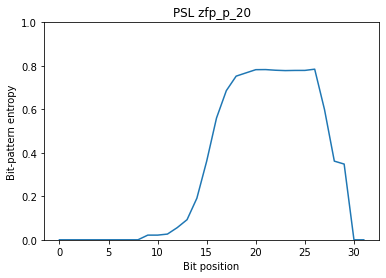

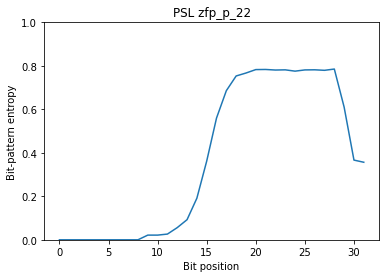

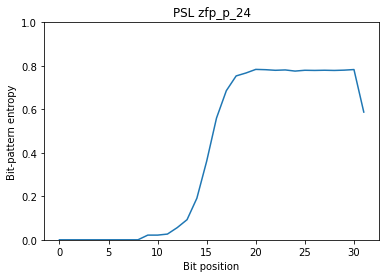

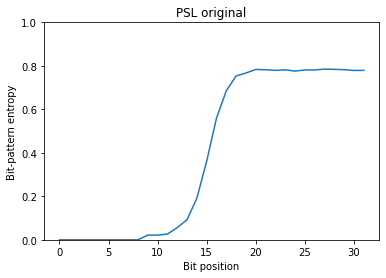

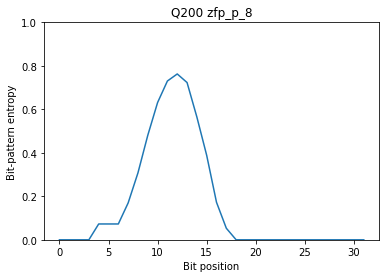

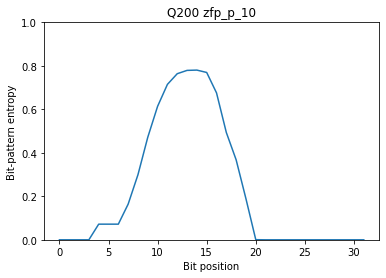

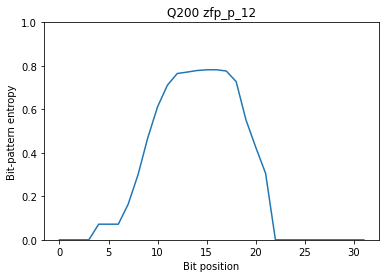

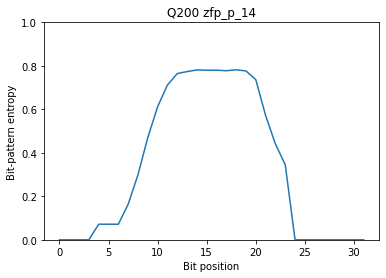

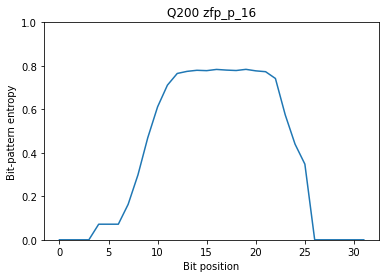

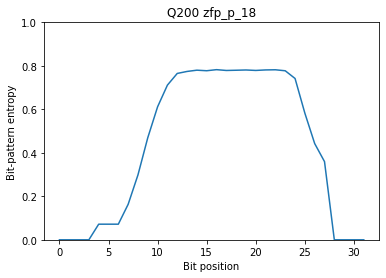

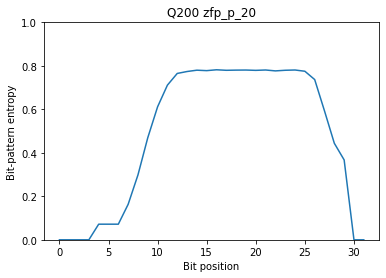

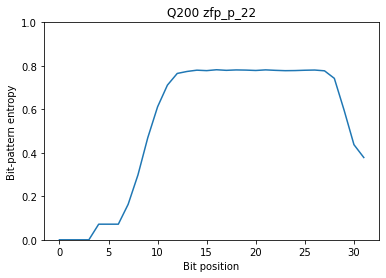

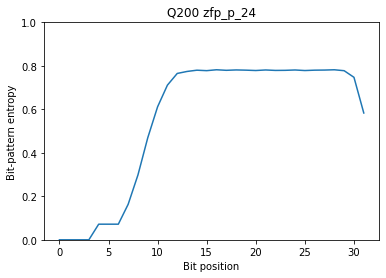

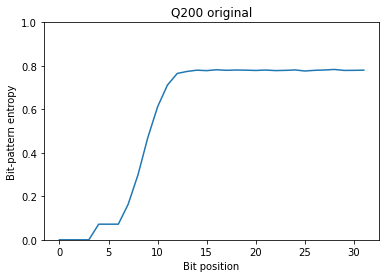

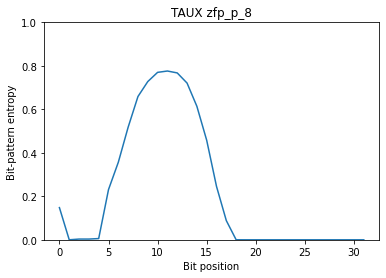

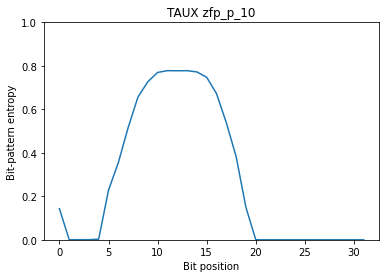

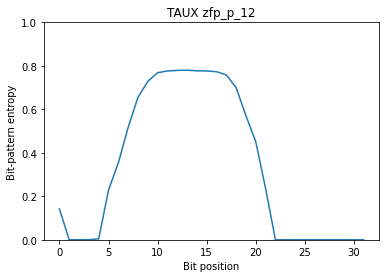

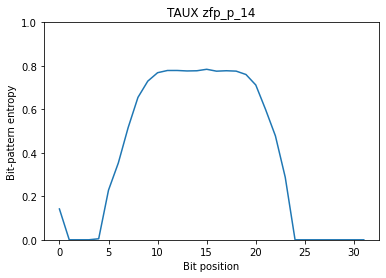

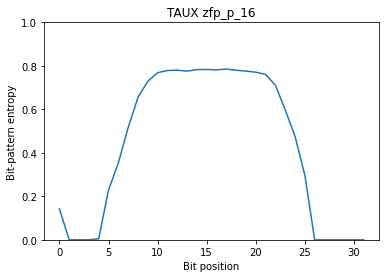

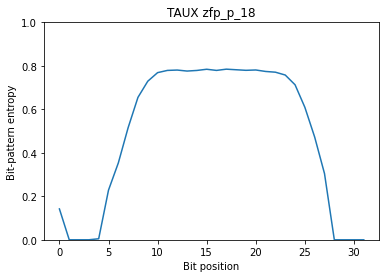

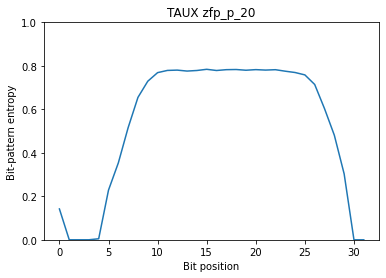

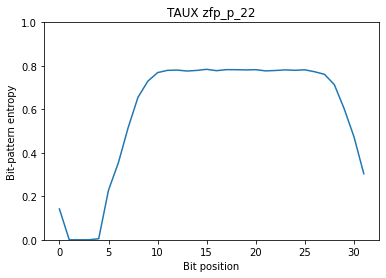

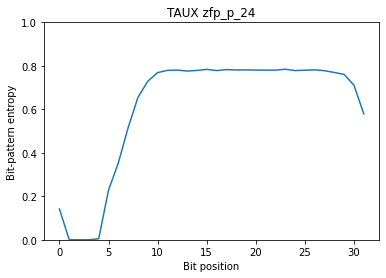

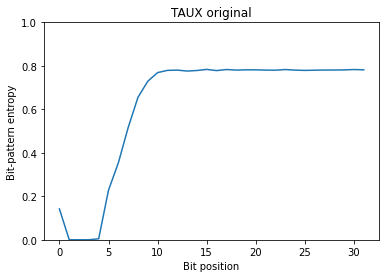

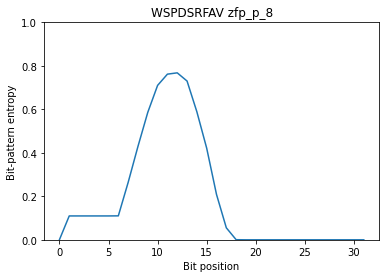

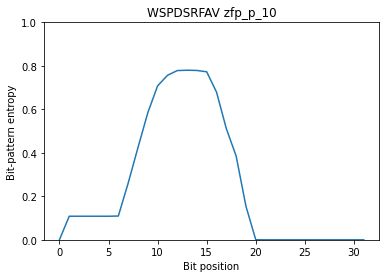

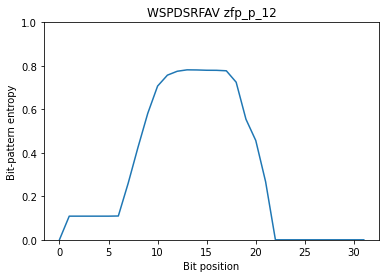

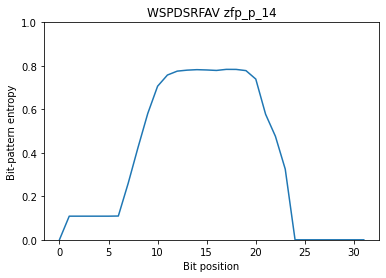

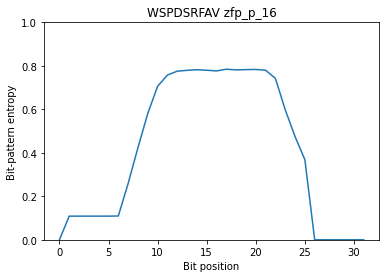

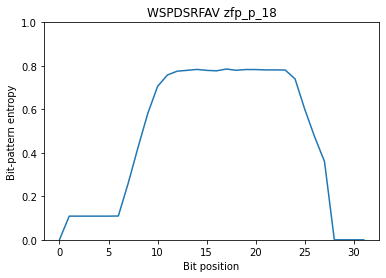

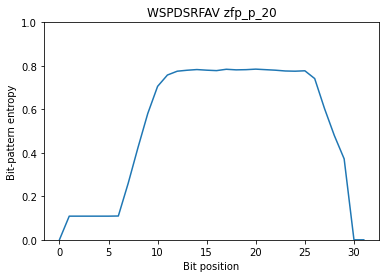

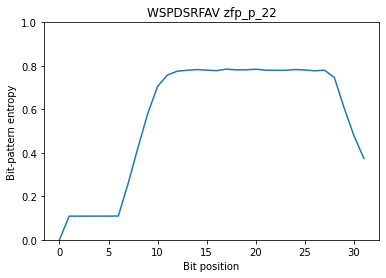

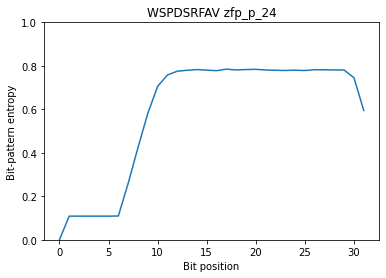

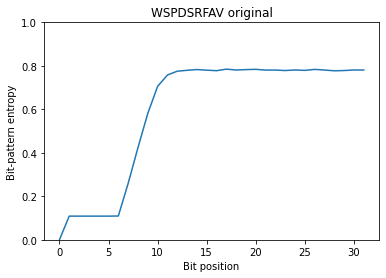

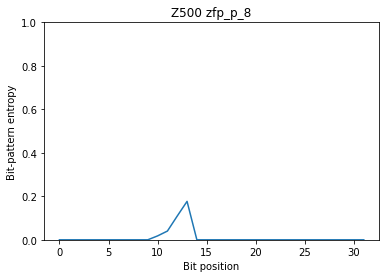

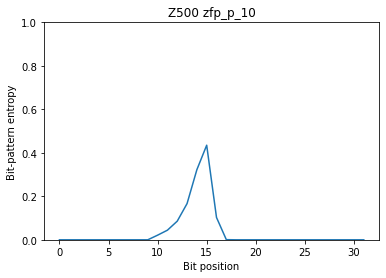

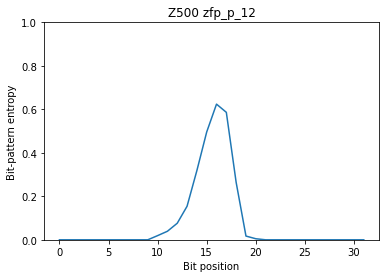

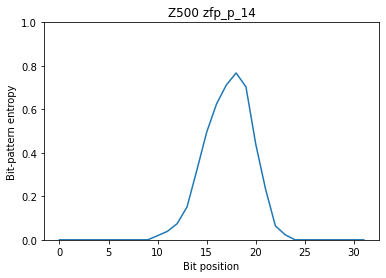

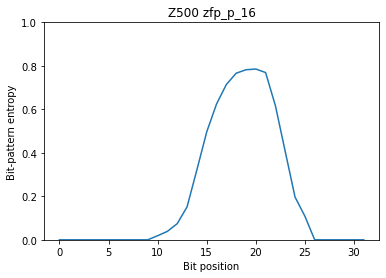

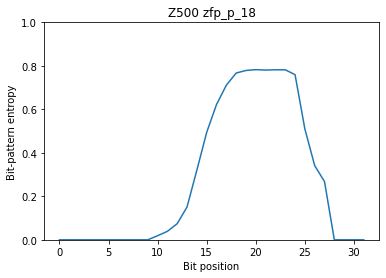

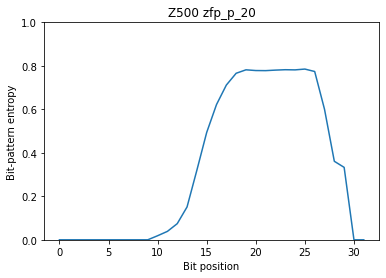

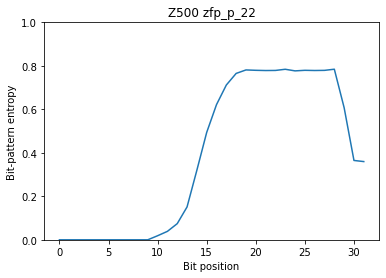

KeyboardInterrupt: 

In [4]:
def binary(num):
    return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', num))

def get_adj_bits(bit_pos):
    adj_points = [
        [bit_pos[0]-1, bit_pos[1]],
        [bit_pos[0]+1, bit_pos[1]],
        [bit_pos[0], bit_pos[1]-1],
        [bit_pos[0], bit_pos[1]+1]
    ]
    return adj_points

N_BITS = 32

def getbpe(ts_array, x_index, title):
    Hs_all = []

    for y in range(1, ts_array.shape[1]-1):
        for z in range(1, ts_array.shape[1]-1):
            bit_pos = [y, z]
            adj_bits = get_adj_bits(bit_pos)
            bit_strings = []
            for adj_bit in adj_bits:
                y_index, z_index = adj_bit
                value = ts_array[x_index][y_index][z_index]
                value = binary(value)
                bit_strings.append(value)

            Hs = [0] * N_BITS
            i = 0
            for a, b, c, d in zip(*bit_strings):
                val_sum = int(a) + int(b) + int(c) + int(d)
                prob_1 = val_sum / len(adj_bits)
                prob_0 = 1 - prob_1
                if prob_0 == 0 or prob_1 == 0:
                    H = 0
                else:
                    H = -prob_0*log2(prob_0) - prob_1*log2(prob_1)
                Hs[i] = H
                i += 1

            Hs_all.append(Hs)


    Hs_all = np.array(Hs_all)

    result = np.sum(Hs_all, axis=0) / Hs_all.shape[0]

    plt.plot(result)
    plt.title(title + " " + zfp_array[x_index])
    plt.ylim(0,1)
    plt.xlabel("Bit position")
    plt.ylabel("Bit-pattern entropy")
    plt.show()


for daily_variable in daily_variables:
    arr = climate_var_arrays[daily_variable]
    for i in range(arr.shape[0]):
        getbpe(arr, i, daily_variable)

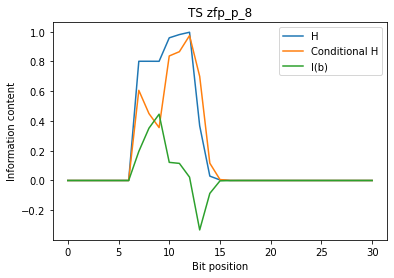

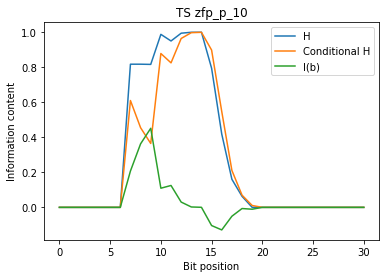

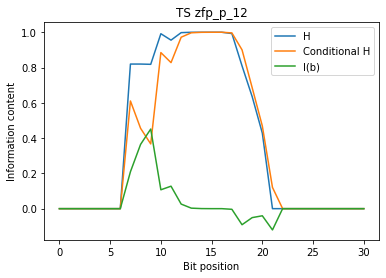

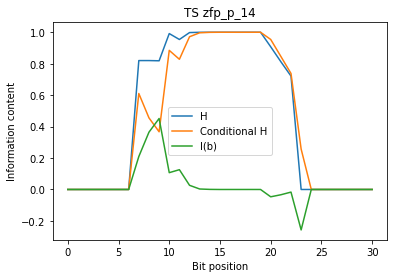

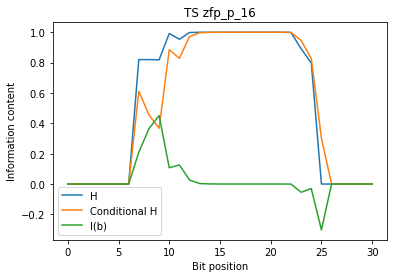

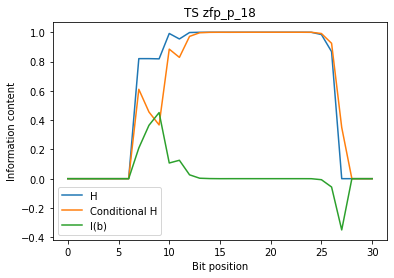

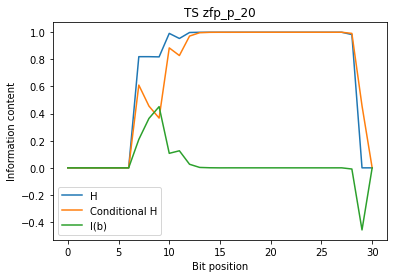

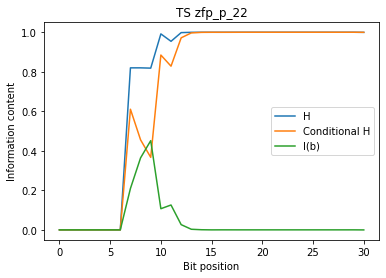

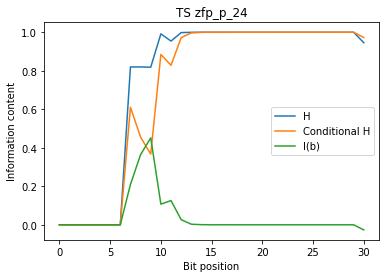

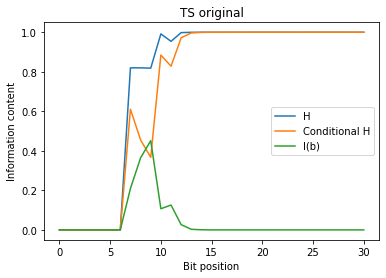

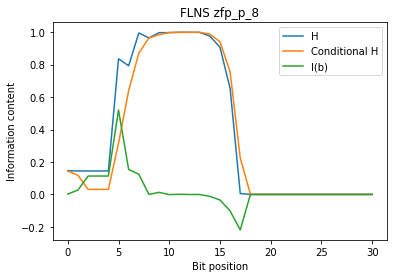

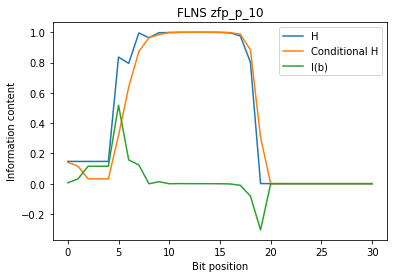

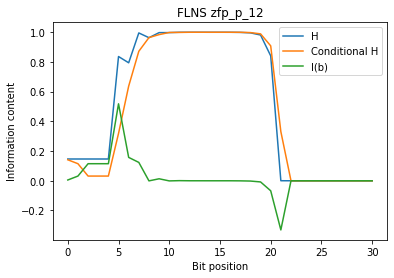

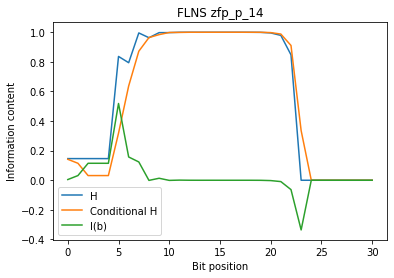

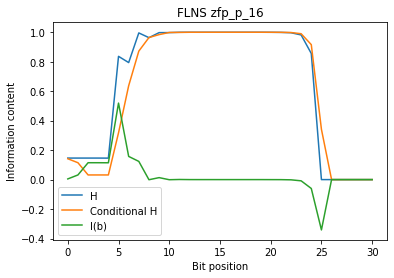

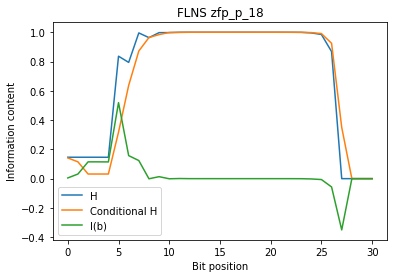

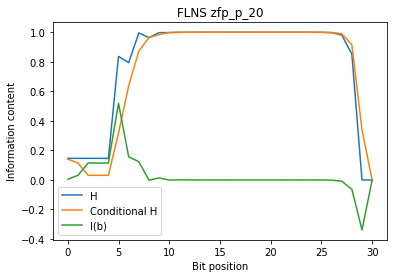

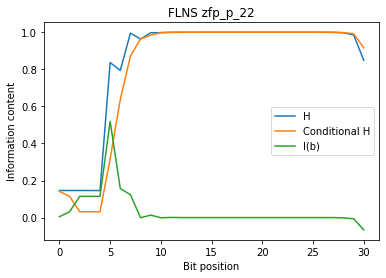

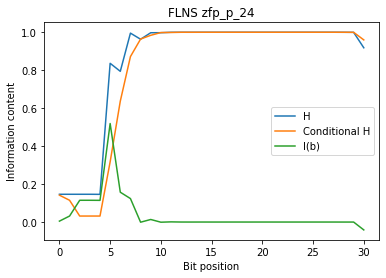

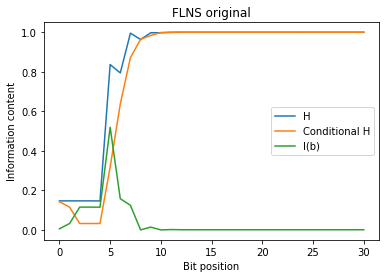

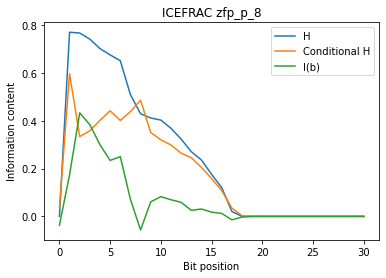

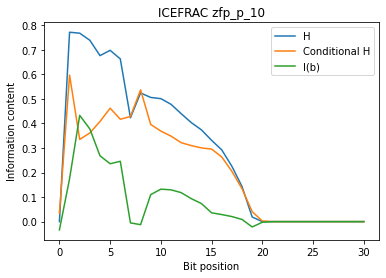

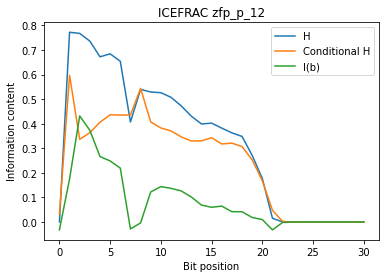

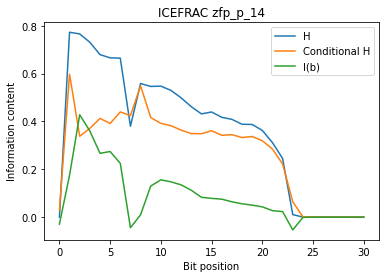

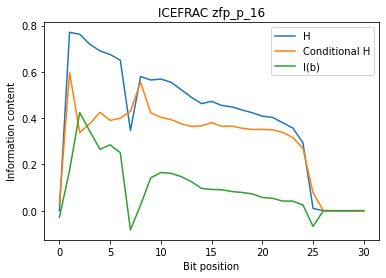

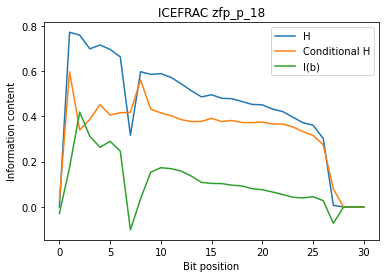

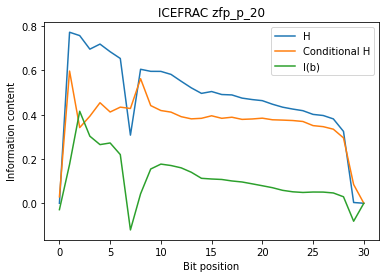

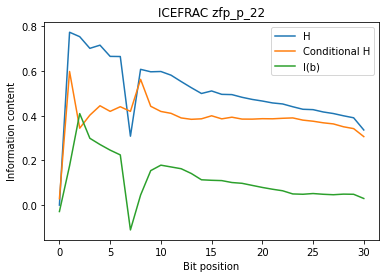

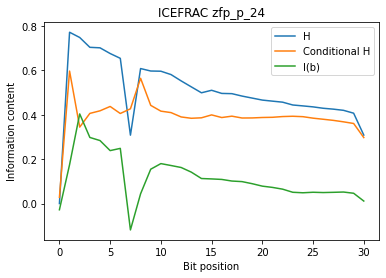

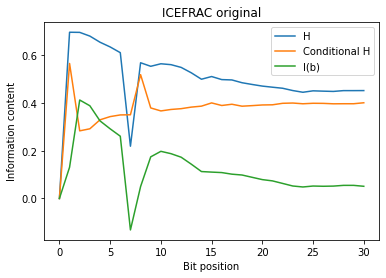

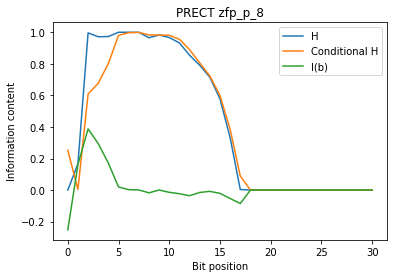

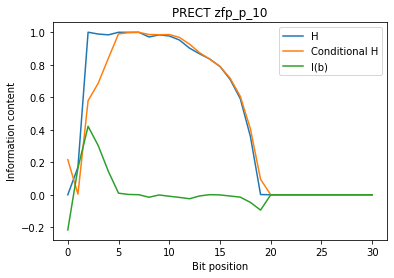

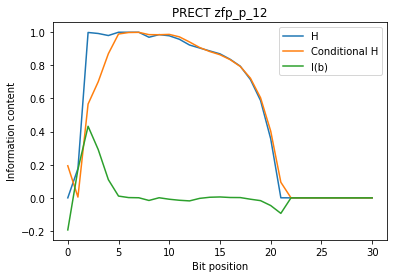

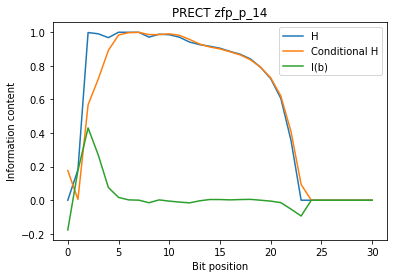

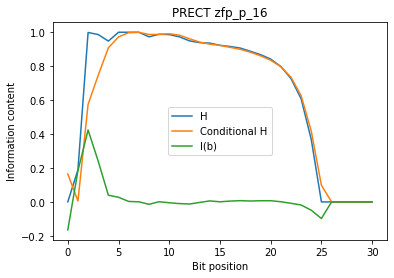

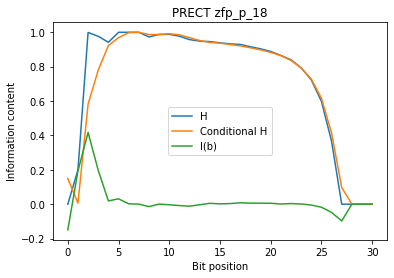

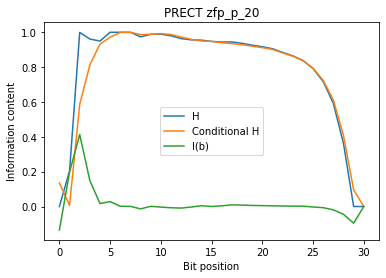

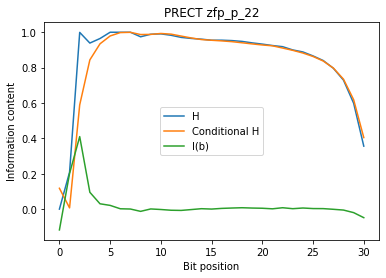

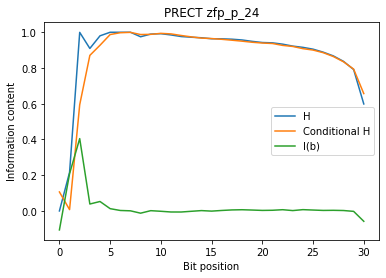

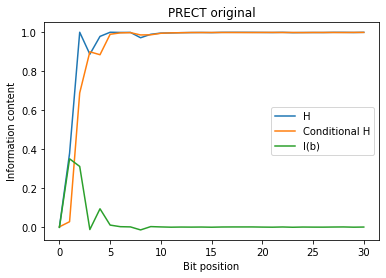

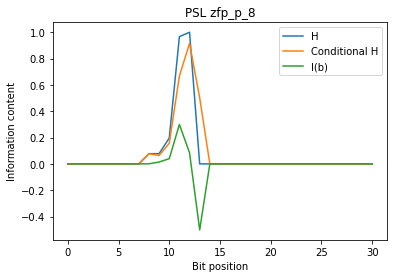

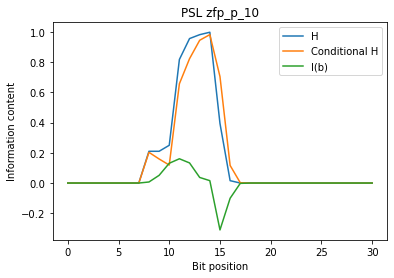

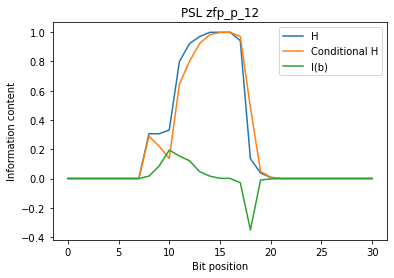

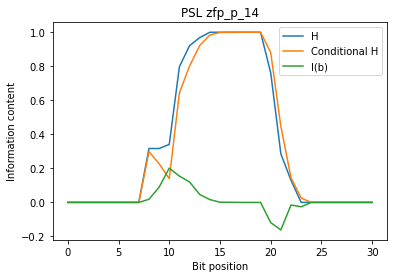

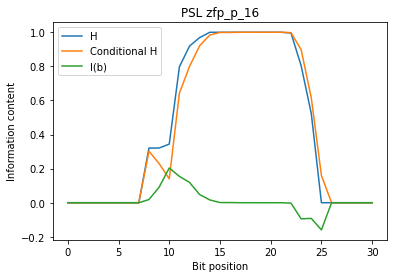

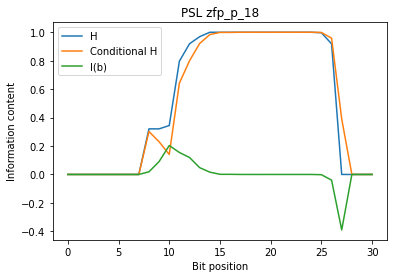

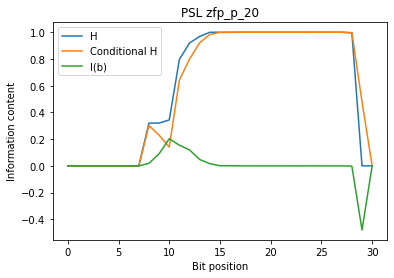

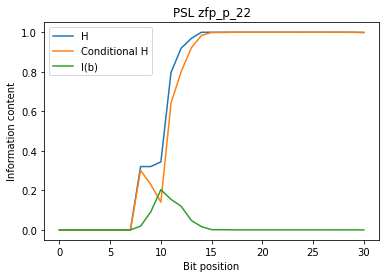

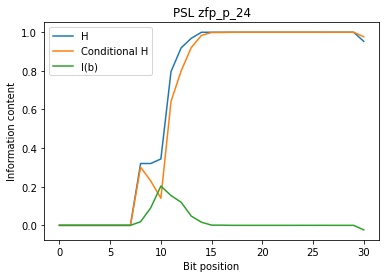

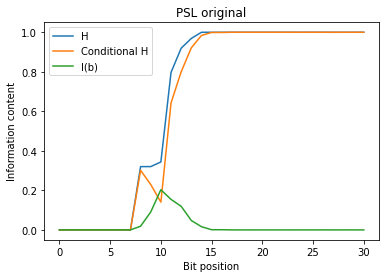

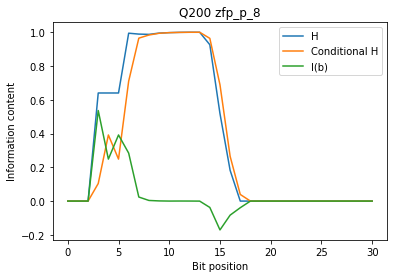

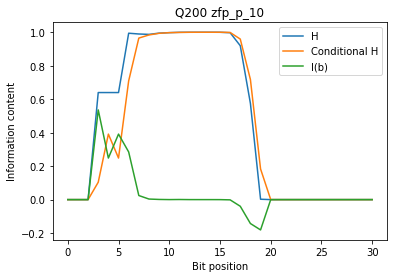

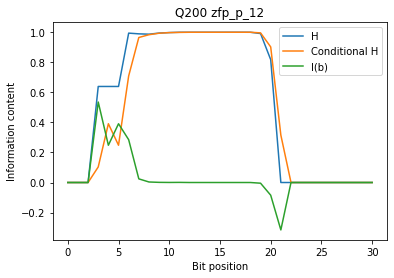

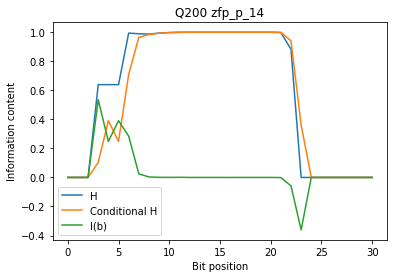

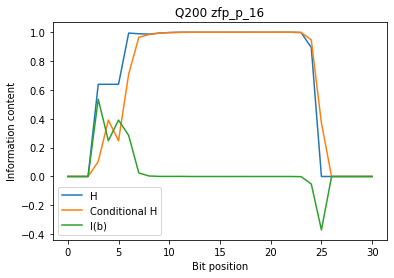

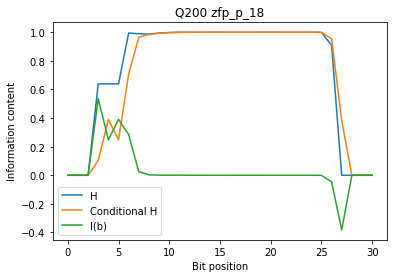

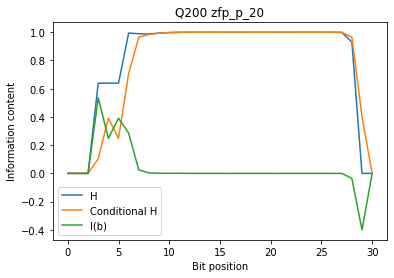

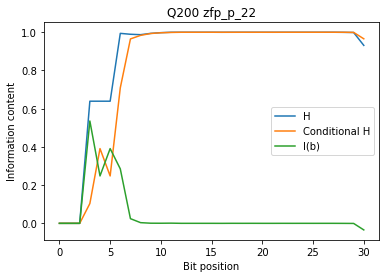

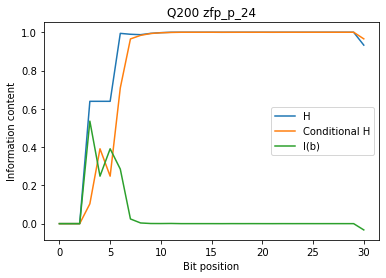

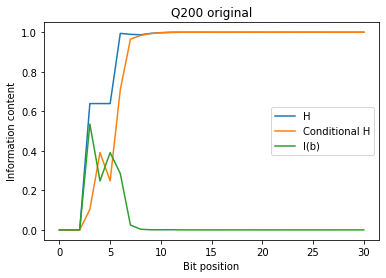

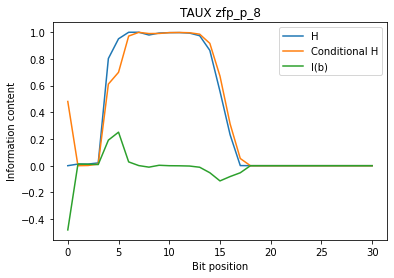

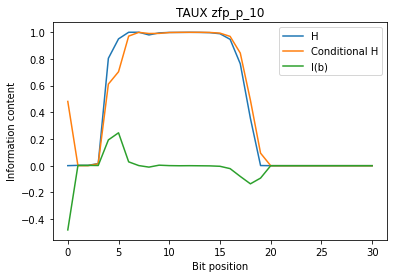

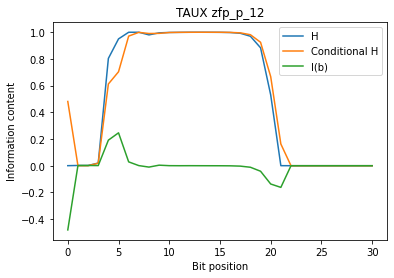

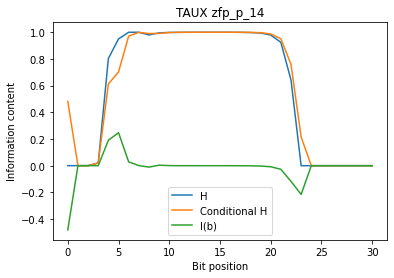

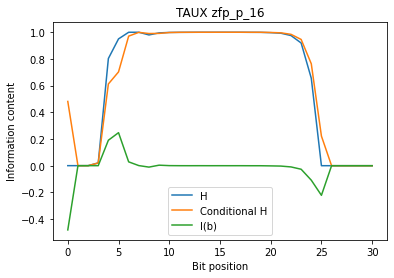

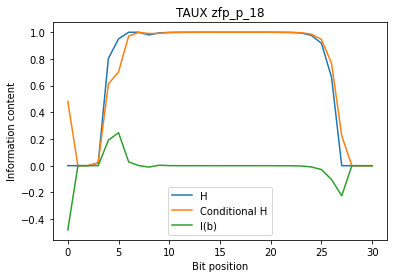

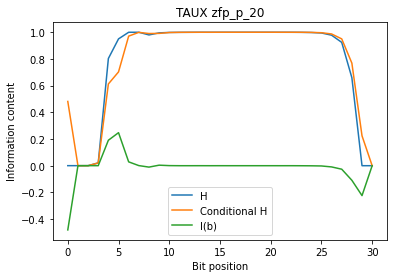

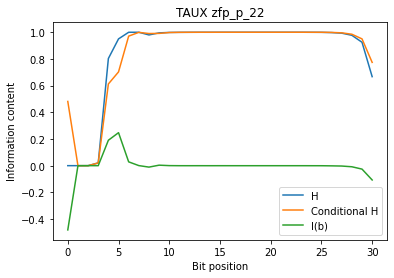

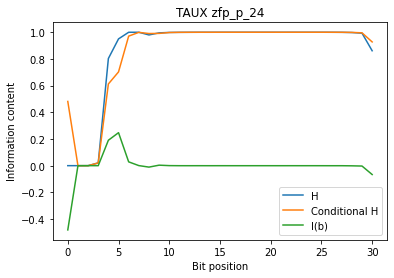

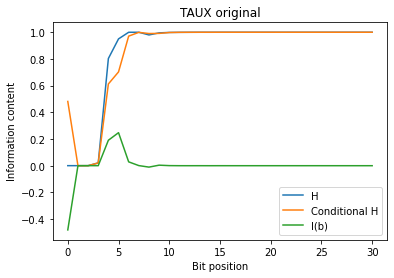

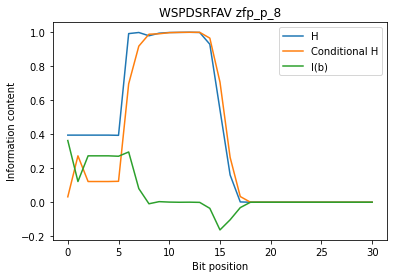

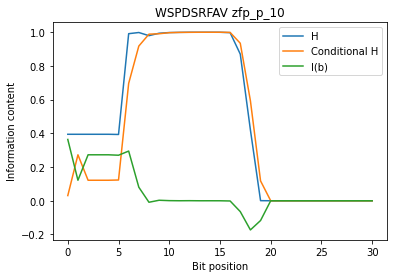

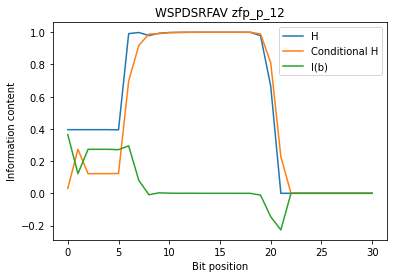

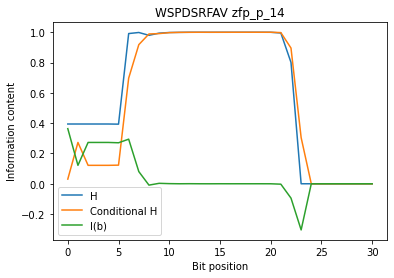

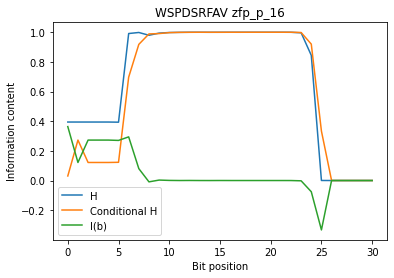

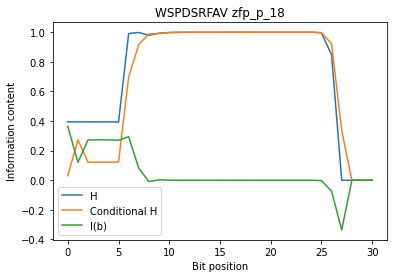

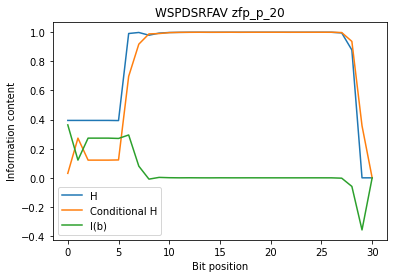

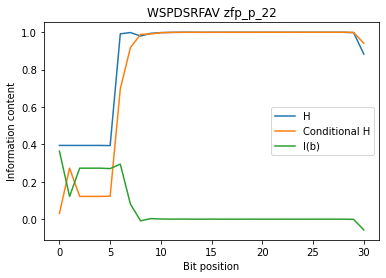

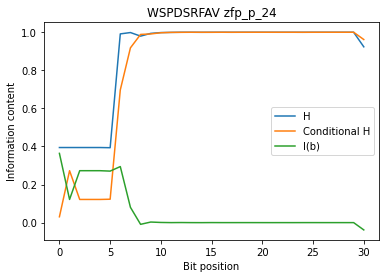

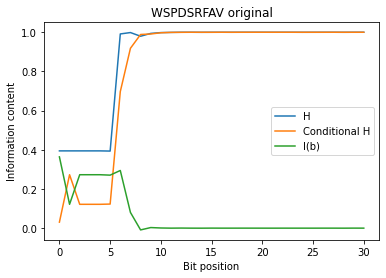

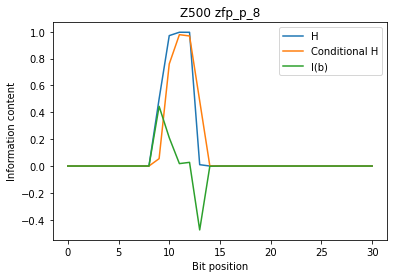

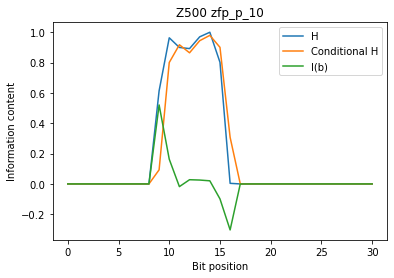

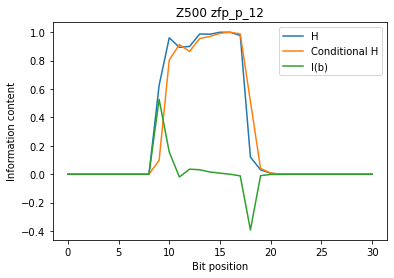

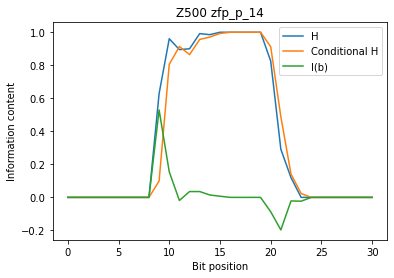

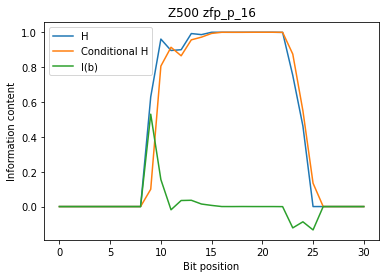

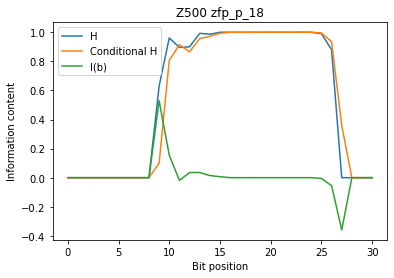

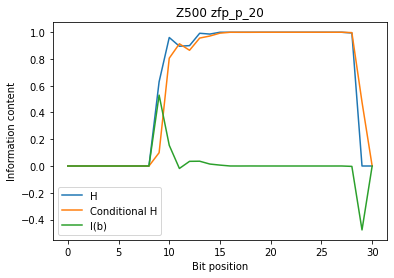

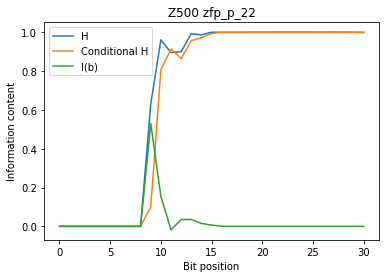

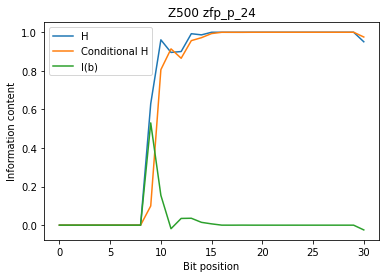

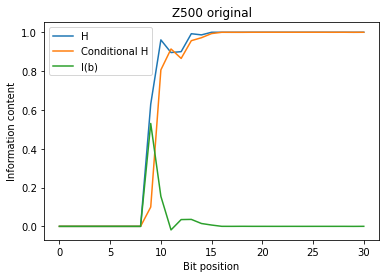

In [8]:
def graph_real_information(ts_array, x_index, title):
    ts_sel = ts_array[x_index, ...].flatten()
    ts_sel_bin = np.array(list(map(binary, ts_sel)))


    dict_list_H = []
    for i in range(N_BITS-1):
        new_dict = {"00": 0,
                    "01": 0,
                    "10": 0,
                    "11": 0,
                    "0": 0,
                    "1": 0}
                    
        dict_list_H.append(new_dict)


    for bin_num in ts_sel_bin:
        for i in range(len(bin_num)-1):
            first_bit = bin_num[i]
            second_bit = bin_num[i+1]

            bits = str(first_bit) + str(second_bit)
            dict_list_H[i][bits] += 1

            dict_list_H[i][second_bit] += 1


    for entry in dict_list_H:
        entropy = 0
        sum_all = entry["00"] + entry["01"] + entry["10"] + entry["11"]
        sum_0_1 = entry["0"] + entry["1"]

        p00 = entry["00"] / sum_all
        p01 = entry["01"] / sum_all
        p10 = entry["10"] / sum_all
        p11 = entry["11"] / sum_all
        p0 = entry["0"] / sum_0_1
        p1 = entry["1"] / sum_0_1

        entropy = 0
        if p0 != 0:
            entropy += p0 * log2(p0)
        if p1 != 0:
            entropy += p1 * log2(p1)

        entropy = -entropy
        entry["H"] = entropy 

        
        H0 = 0
        if p00 != 0:
            H0 += p00 * log2(p00)

        if p01 != 0:
            H0 += p01 * log2(p01)

        H1 = 0
        if p10 != 0:
            H1 += p10 * log2(p10)
        
        if p11 != 0:
            H1 += p11 * log2(p11)

        prob_H = -p0*H0 - p1*H1

        entry["prob_H"] = prob_H

        real_information = entropy - prob_H
        entry["real_information"] = real_information

    H = [x["H"] for x in dict_list_H]
    prob_H = [x["prob_H"] for x in dict_list_H]
    real_information = [x["real_information"] for x in dict_list_H]

    plt.plot(H)
    plt.plot(prob_H)
    plt.plot(real_information)
    plt.ylabel("Information content")
    plt.xlabel("Bit position")
    plt.title(title + " " + zfp_array[x_index])
    plt.legend(["H", "Conditional H", "I(b)"])
    plt.show()

for daily_variable in daily_variables:
    arr = climate_var_arrays[daily_variable]
    for i in range(arr.shape[0]):
        graph_real_information(arr, i, daily_variable)